In [3]:
!pip install gensim

  Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached gensim-4.3.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.5 MB)


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer

from scipy.cluster.hierarchy import ward, dendrogram, fcluster
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.model_selection import train_test_split
from gensim.models import FastText

In [2]:
embeddings = pd.read_pickle("./data/clean_2020articles_w_title_embeddings.pkl")

In [4]:
# embeddings

In [3]:
train, test = train_test_split(embeddings, test_size=0.4, random_state=42)

In [27]:
corpus = train.loc[:, 'title']
#corpus

4594     south dakota governor: election a ‘choice’ bet...
10698    ilhan omar: many who want to ‘prematurely reop...
19212    perdue: ‘who would believe that you could spen...
28302              nancy pelosi: everything we’re doing...
36418    georgia's republican u.s. senators call on gop...
                               ...                        
16850    joe biden sought ‘grand bargain’ to reduce def...
6265     world health organization: abortion is ‘essent...
11284    dick cheney’s former cardiologist: trump has 1...
860      matt gaetz: if swalwell can say his sex life i...
15795    watch: hecklers during live shot shout ‘cnn is...
Name: title, Length: 3704, dtype: object

In [28]:
# cv = CountVectorizer(ngram_range=(1, 2), min_df=0.001, max_df=0.99)
# cv_matrix = cv.fit_transform(corpus)
# cv_matrix.shape

In [29]:
# tokenizing title docs
tokenized_docs = [doc.split() for doc in corpus]
ft_model = FastText(tokenized_docs, vector_size=512, window=20, min_count=2, 
                    workers=1, sg=1, seed=42, epochs=10)

In [30]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)

    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.

        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                for tokenized_sentence in corpus]
    return np.array(features)

In [11]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 512)
doc_vecs_ft.shape


(37, 512)

In [12]:
# doc_vecs_ft[0]

In [5]:
train["bert_embeddings"] = train["bert_sentence_embedding_title_only"].apply(lambda x: x.cpu())
train["np_embeddings"] = train["bert_embeddings"].apply(lambda x: x.numpy())
np_embedding = np.vstack(train["np_embeddings"])

In [6]:
np_embedding.shape[0]

22226

In [7]:
def ward_hierarchical_clustering(feature_matrix):
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_hierarchical_clusters(linkage_matrix, data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    titles = data['title'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left",
                   truncate_mode='lastp',
                   p=p,
                   no_plot=True)
    temp = {R["leaves"][ii]: titles[ii] for ii in range(len(R["leaves"]))}

    def llf(xx):
        return "{}".format(temp[xx])

    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,
            leaf_label_func=llf,
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig(f'./data/bert_hierachical_clusters_num_docs_{data.shape[0]}_level_{p}.png', dpi=200)

In [9]:
bert_linkage_matrix = ward_hierarchical_clustering(np_embedding)

In [ ]:
fast_text_linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

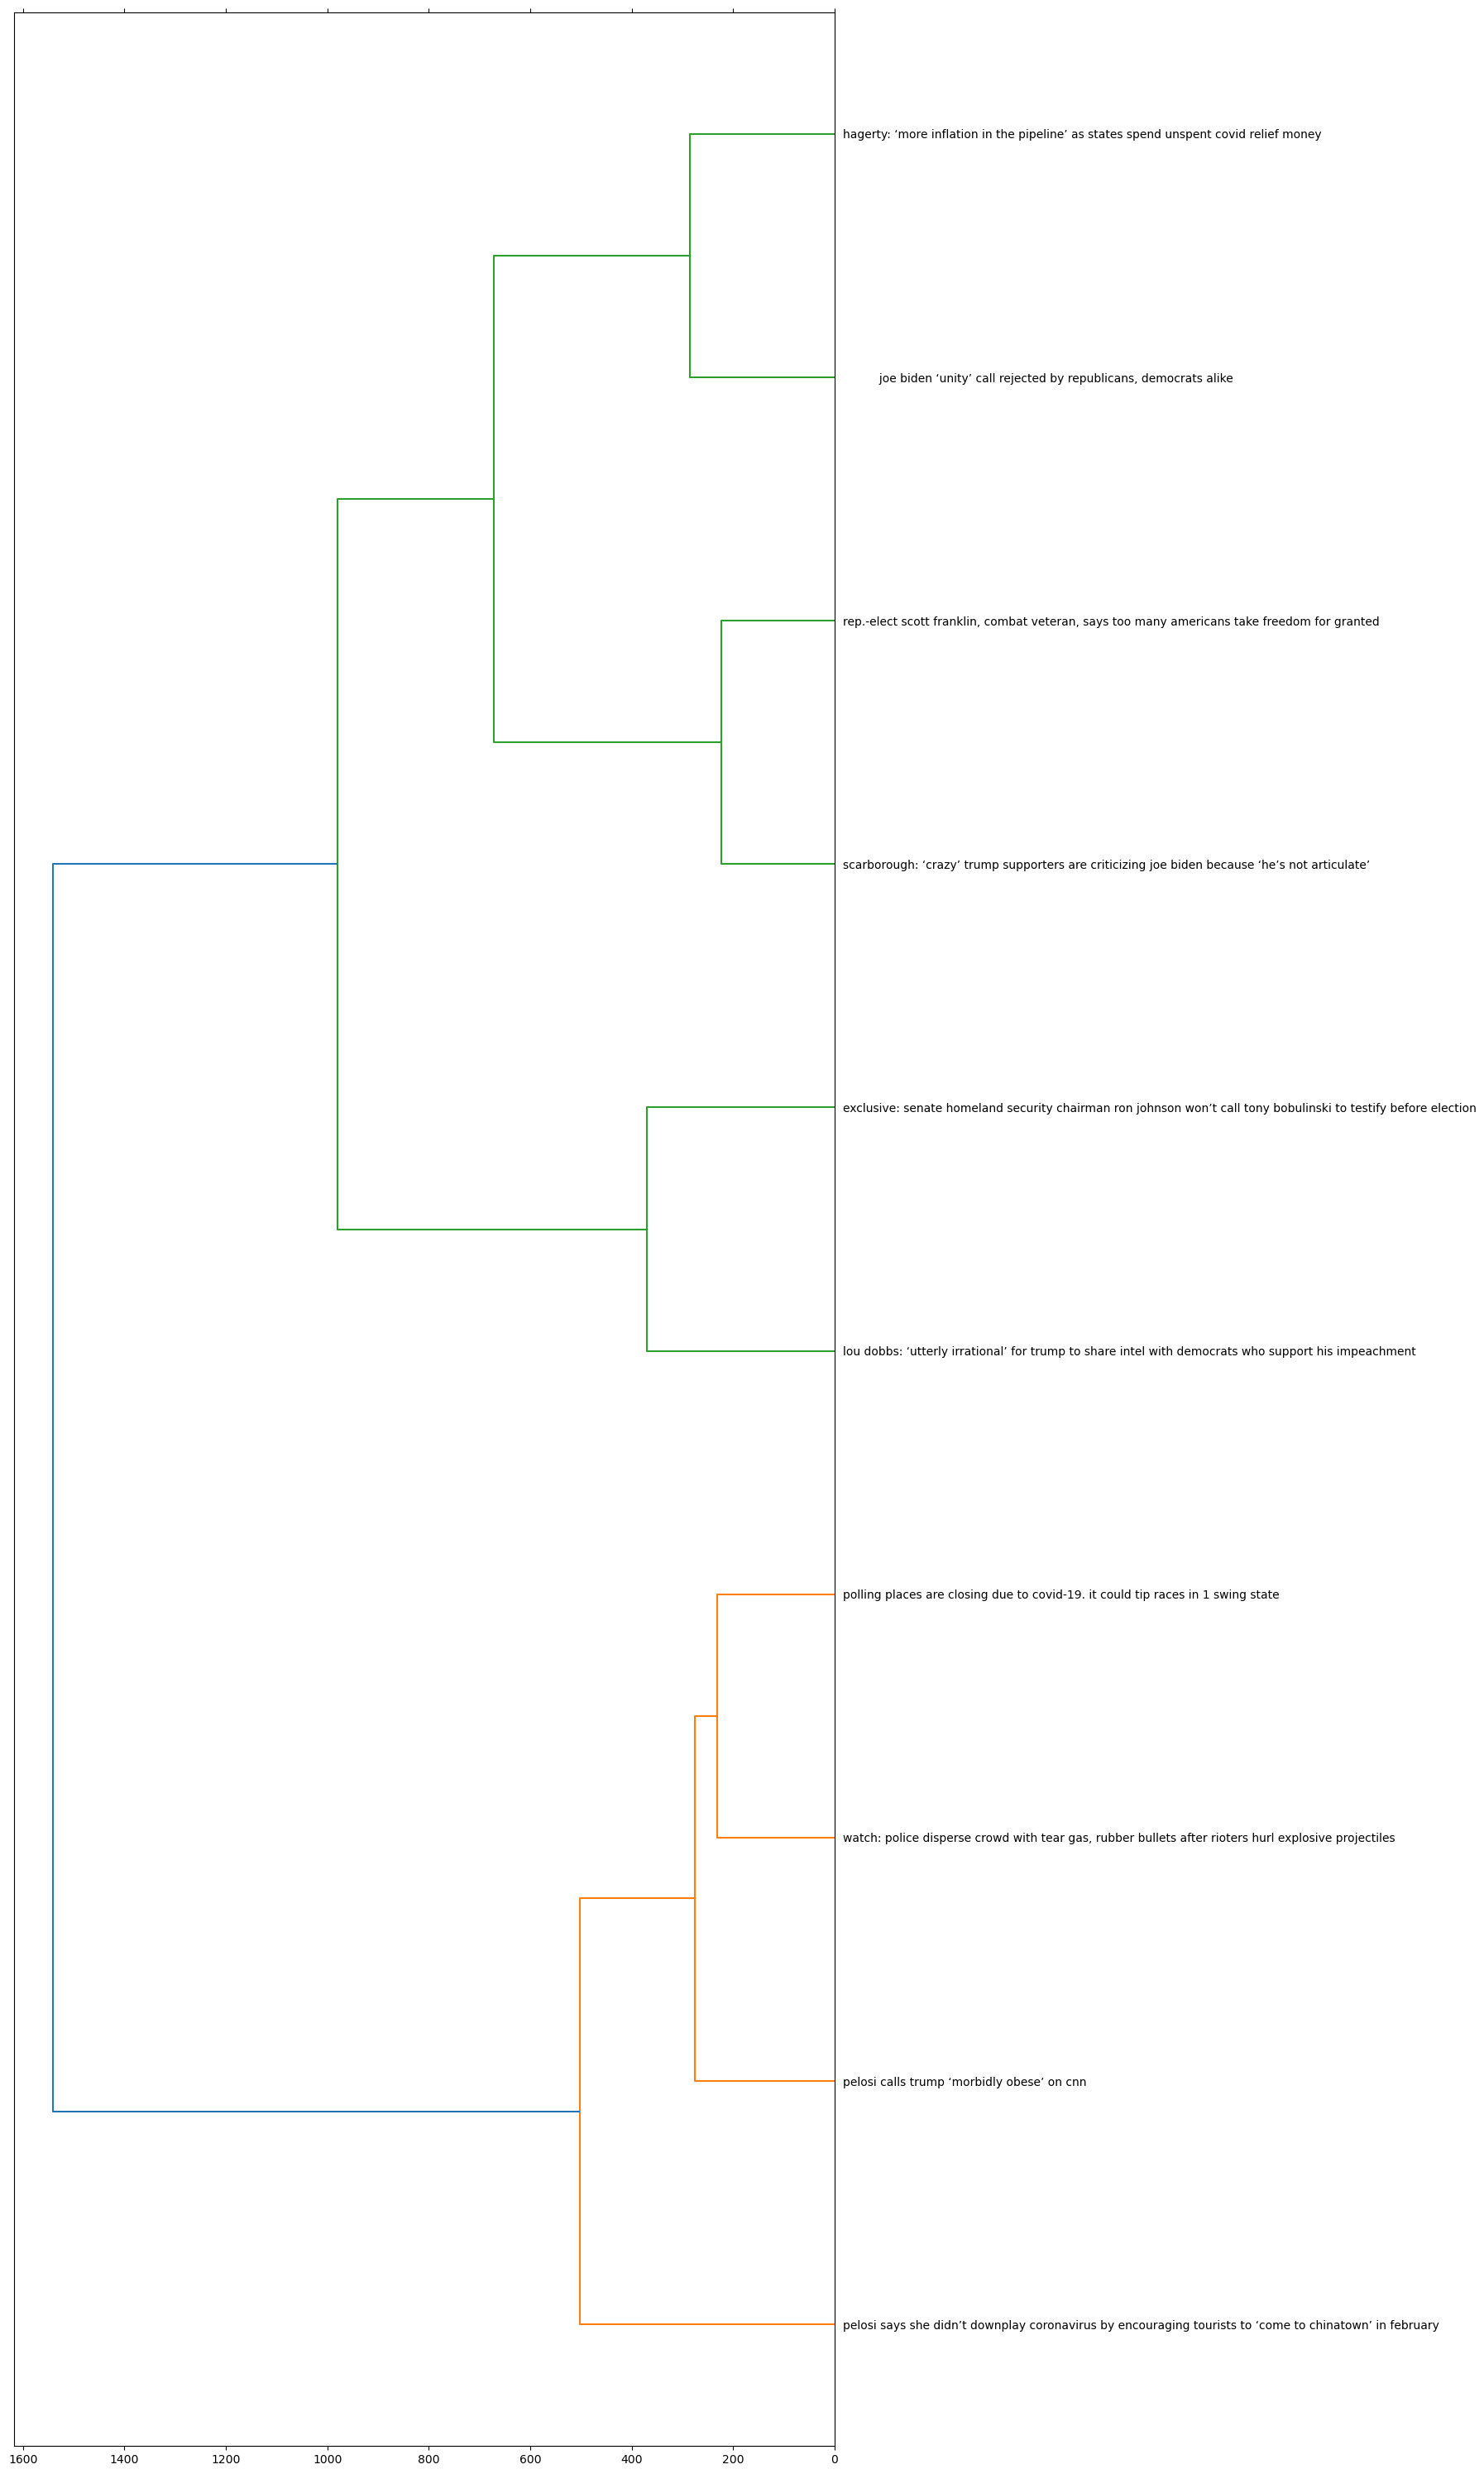

In [10]:
plot_hierarchical_clusters(bert_linkage_matrix,
                           p=10,
                           data=train,
                           figure_size=(18, 30))

KeyboardInterrupt: 

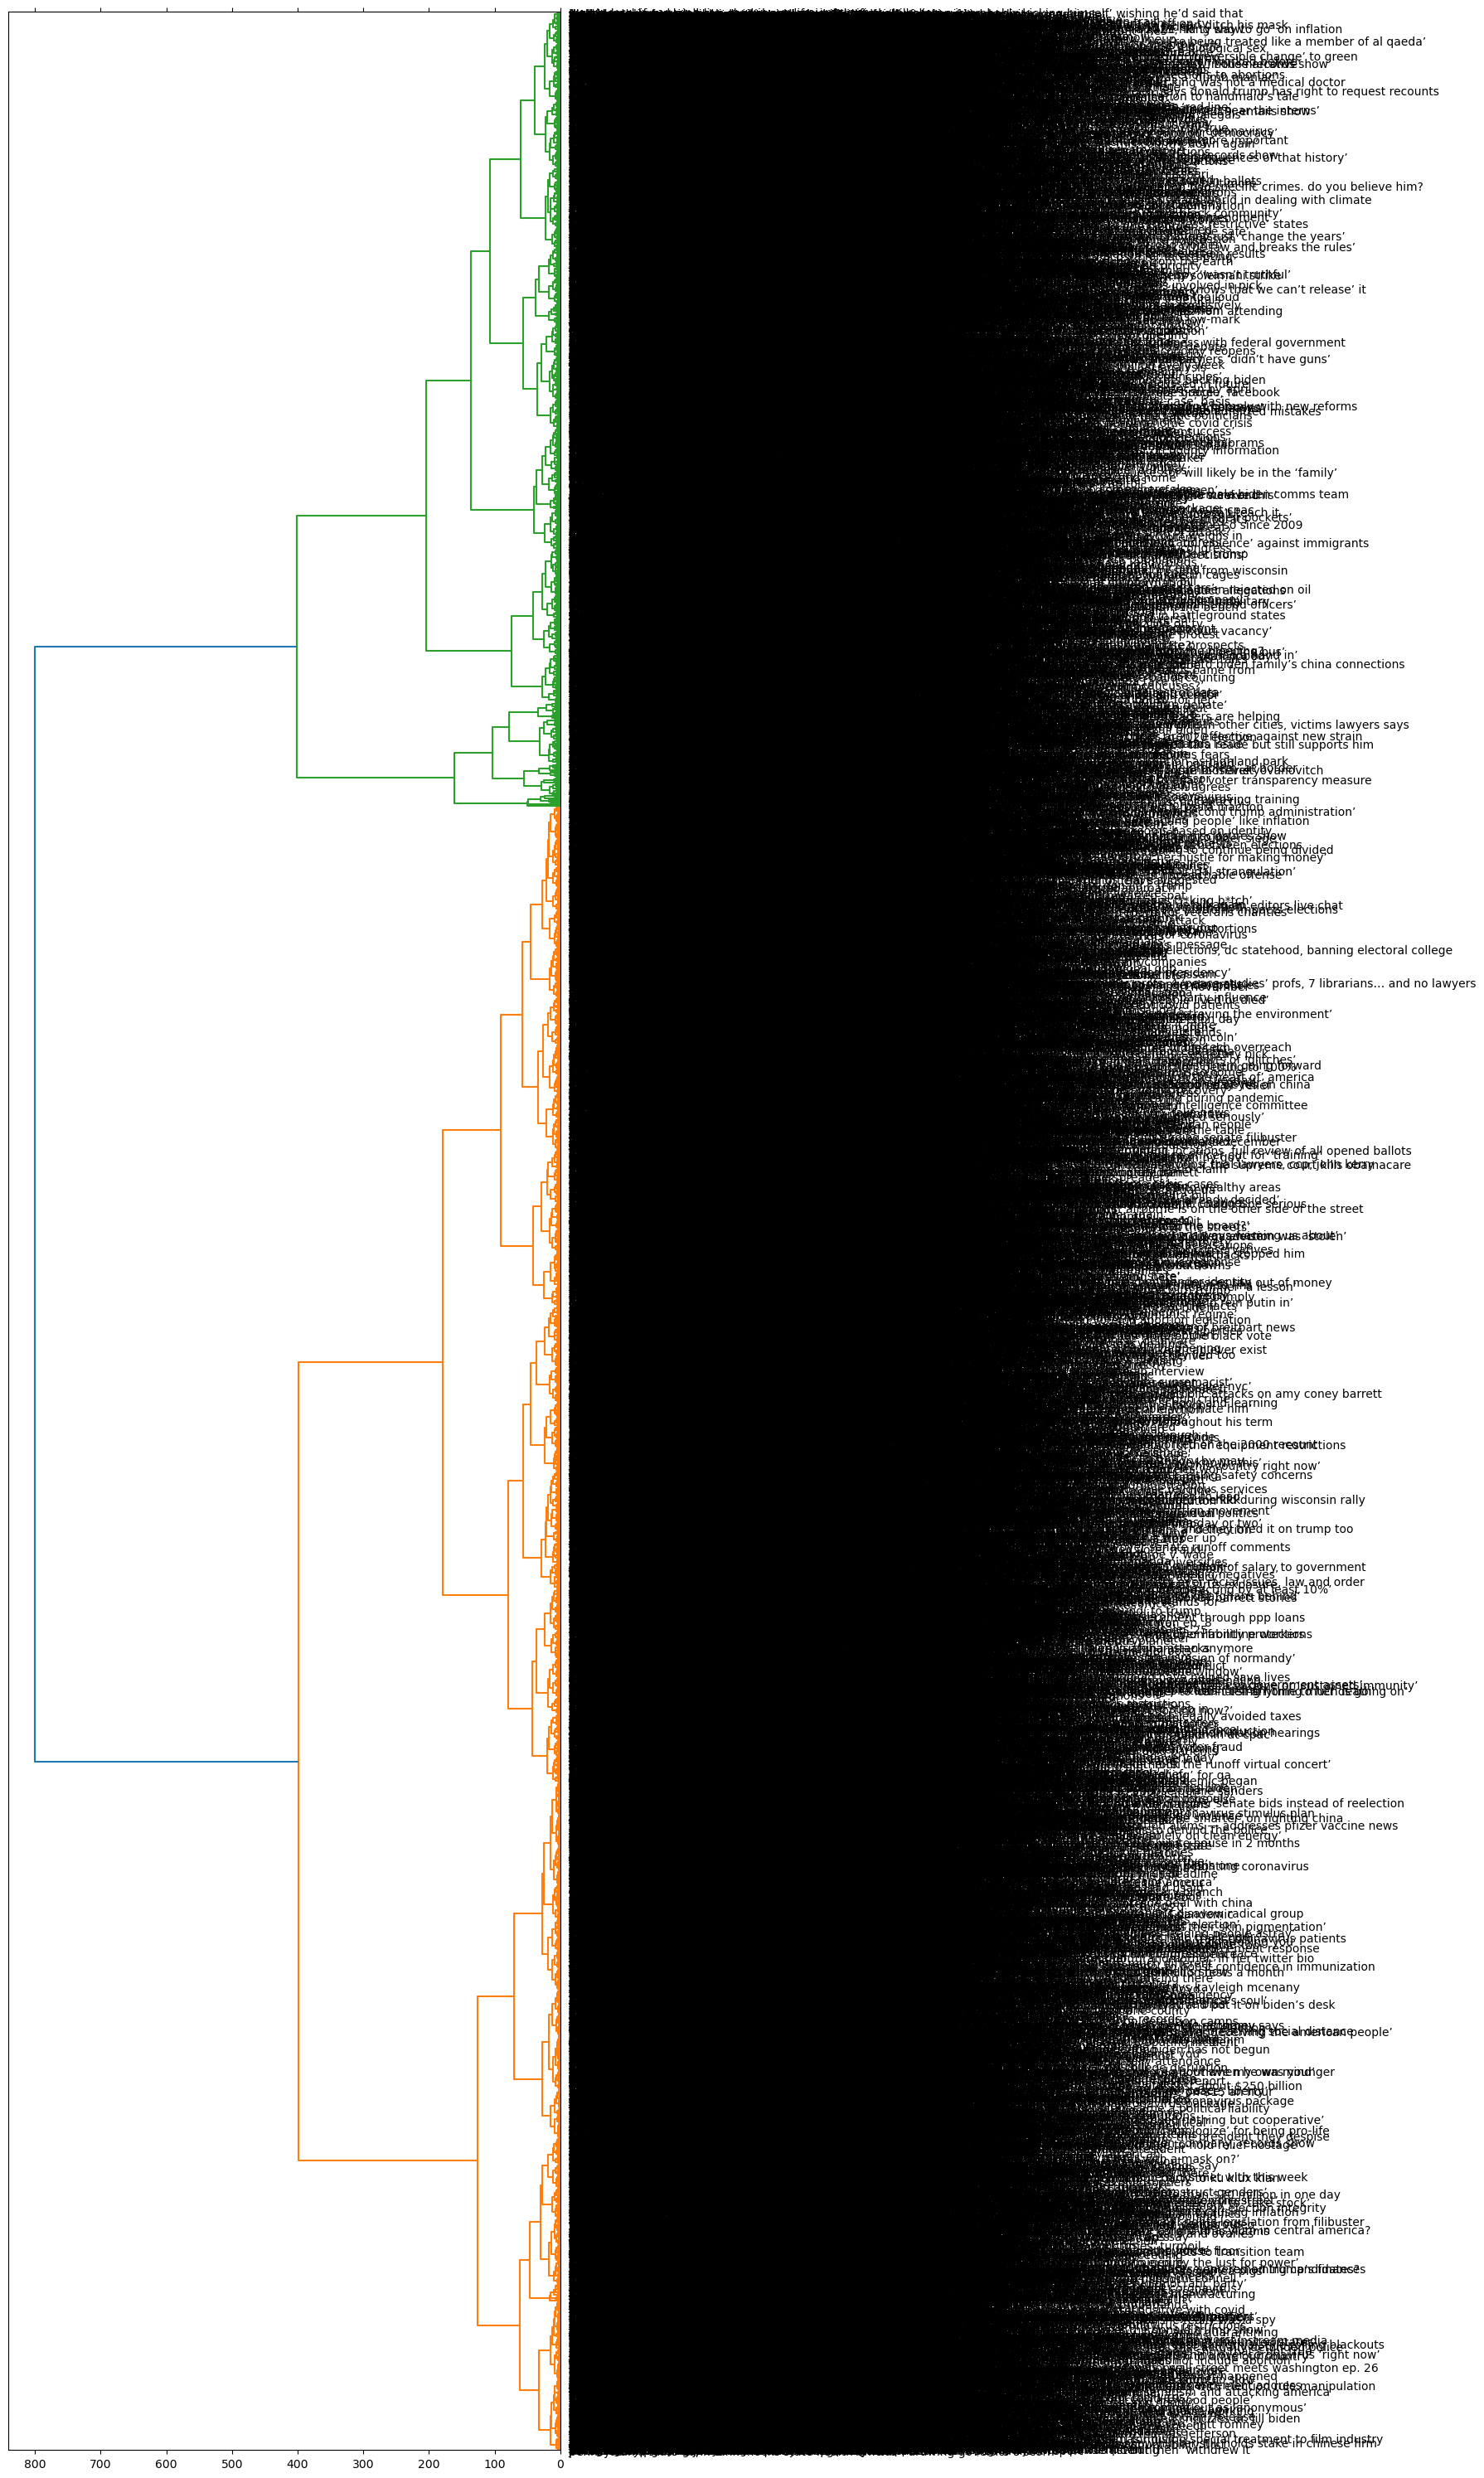

In [77]:
plot_hierarchical_clusters(bert_linkage_matrix,
                           p=100,
                           data=train,
                           figure_size=(18, 30))

In [13]:
# This actually assigns a cluster number to each item depending on a certain cutoff point
# using a distance of 15 would give us 27 clusters!!
fcluster(bert_linkage_matrix, 20, criterion='distance').max()

233

In [12]:
fcluster(bert_linkage_matrix, 0.3, criterion='distance')

array([ 1701,  1663, 19423, ..., 12209,  7661,  7582], dtype=int32)

In [ ]:
# TODO map cluster numbers back to articles in training set and doo topic analysis

In [23]:
bert_linkage_matrix.shape

(22225, 4)

In [22]:
np_embedding.shape

(22226, 768)

In [26]:
len(train)

22226

In [25]:
train['linkage_matrix'] = bert_linkage_matrix

ValueError: Length of values (22225) does not match length of index (22226)

In [27]:
backup = train.copy()
backup.head()

,uuid,source,year,article_text,title,title_text,bert_sentence_embedding_title_only,bert_embeddings,np_embeddings
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...,"[tensor(-0.0107, device='cuda:0'), tensor(-0.0...","[tensor(-0.0107), tensor(-0.0400), tensor(0.06...","[-0.010705581, -0.039960533, 0.06233001, -0.17..."
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...,"[tensor(0.0036, device='cuda:0'), tensor(-0.01...","[tensor(0.0036), tensor(-0.0126), tensor(0.080...","[0.0035614772, -0.012626172, 0.08044264, 0.044..."
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru...","[tensor(0.0761, device='cuda:0'), tensor(-0.34...","[tensor(0.0761), tensor(-0.3431), tensor(0.384...","[0.076130114, -0.3430872, 0.3845805, -0.017871..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...,"[tensor(-0.3777, device='cuda:0'), tensor(-0.3...","[tensor(-0.3777), tensor(-0.3499), tensor(0.46...","[-0.3777309, -0.3499137, 0.4649744, 0.49654028..."
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...,"[tensor(-0.5613, device='cuda:0'), tensor(-0.1...","[tensor(-0.5613), tensor(-0.1421), tensor(-0.1...","[-0.5612726, -0.14205904, -0.19704106, 0.15212..."


In [34]:
train['cluster_id'] = -1
train.head(2)

,uuid,source,year,article_text,title,title_text,bert_sentence_embedding_title_only,bert_embeddings,np_embeddings,cluster_id
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...,"[tensor(-0.0107, device='cuda:0'), tensor(-0.0...","[tensor(-0.0107), tensor(-0.0400), tensor(0.06...","[-0.010705581, -0.039960533, 0.06233001, -0.17...",-1
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...,"[tensor(0.0036, device='cuda:0'), tensor(-0.01...","[tensor(0.0036), tensor(-0.0126), tensor(0.080...","[0.0035614772, -0.012626172, 0.08044264, 0.044...",-1


In [40]:
# np.save('./data/bert_22kdocs_bert_embedding_linkage_matrix.npy', bert_linkage_matrix)

In [43]:
train_df = train.copy()
train_df = train_df.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings', 'cluster_id'], axis=1)
train_df.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [47]:
# train_df.to_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv') 

In [50]:
# test_train_df = pd.read_csv('./data/bert_22kdocs_bert_embedding_linkage_matrix_matching_training_df.csv', index_col=0)
# test_train_df.head()

,uuid,source,year,article_text,title,title_text
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru..."
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...


In [51]:
# Extracting cluster information
# clusters = {}
# for i, merge in enumerate(bert_linkage_matrix):
#     cluster_id = i + len(train)  # Cluster IDs start from len(X) and increment
#     left_child = int(merge[0])
#     right_child = int(merge[1])
#     distance = merge[2]
#     clusters[cluster_id] = {'left': left_child, 'right': right_child, 'distance': distance}

# for cluster_id, info in clusters.items():
#     left_row = train.iloc[info['left']]
#     right_row = train.iloc[info['right']]
#     print(f"Cluster {cluster_id}: Left Row - {left_row}, Right Row - {right_row}")

In [152]:
# train_cluster_assignments = train.copy()
# train_cluster_assignments = train_cluster_assignments.drop(['bert_sentence_embedding_title_only', 'bert_embeddings', 'np_embeddings'], axis=1)
distance_options = [1, 5, 10, 20, 30, 50, 100, 150, 200]
for opt in distance_options:
    cluster_assignment = fcluster(bert_linkage_matrix, opt, criterion='distance')
    print(f'dist: {opt} num_clusters: {cluster_assignment.max()}')
    train_cluster_assignments[f'cluster_dist_{opt}'] = cluster_assignment
    

dist: 150 num_clusters: 14


In [153]:
train_cluster_assignments

,uuid,source,year,article_text,title,title_text,cluster_dist_1,cluster_dist_5,cluster_dist_10,cluster_dist_20,cluster_dist_30,cluster_dist_50,cluster_dist_100,cluster_dist_200,cluster_dist_150
6025,c6f115b2-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,house speaker nancy pelosi dismissed the idea ...,pelosi says she didn’t downplay coronavirus by...,pelosi says she didn’t downplay coronavirus by...,1671,70,18,7,4,3,1,1,1
5418,95cae34e-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,speaker of the house nancy pelosi called presi...,pelosi calls trump ‘morbidly obese’ on cnn,pelosi calls trump ‘morbidly obese’ on cnn spe...,1633,68,17,6,4,3,1,1,1
14686,b2f2b844-411f-11ee-a96e-33dec8f414a2,breitbart,2020,kenosha police units determined to enforce the...,"watch: police disperse crowd with tear gas, ru...","watch: police disperse crowd with tear gas, ru...",19234,2849,696,200,104,53,20,9,12
35332,c8b20d44-4136-11ee-a96e-33dec8f414a2,npr,2020,"fromby \n \n kate payne\n \n , ...",polling places are closing due to covid-19. it...,polling places are closing due to covid-19. it...,12190,1541,399,122,66,36,14,7,10
23999,7d814407-3da8-11ee-a96e-33dec8f414a2,dailycaller,2020,fox business network host lou dobbs argued fri...,lou dobbs: ‘utterly irrational’ for trump to s...,lou dobbs: ‘utterly irrational’ for trump to s...,8573,710,185,55,30,13,5,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16850,b41590a8-411f-11ee-a96e-33dec8f414a2,breitbart,2020,"joe biden, the democratic presidential nominee...",joe biden sought ‘grand bargain’ to reduce def...,joe biden sought ‘grand bargain’ to reduce def...,1881,88,23,9,5,3,1,1,1
6265,d2e44638-3da7-11ee-a96e-33dec8f414a2,dailycaller,2020,abortion is considered an essential service du...,world health organization: abortion is ‘essent...,world health organization: abortion is ‘essent...,10127,906,239,69,38,19,7,4,5
11284,b100c193-411f-11ee-a96e-33dec8f414a2,breitbart,2020,"appearing tuesday on cnn, dr. jonathan reiner,...",dick cheney’s former cardiologist: trump has 1...,dick cheney’s former cardiologist: trump has 1...,12026,1498,392,119,64,35,14,7,10
860,5a705610-3da6-11ee-a96e-33dec8f414a2,dailycaller,2020,republican florida rep. matt gaetz commented t...,matt gaetz: if swalwell can say his sex life i...,matt gaetz: if swalwell can say his sex life i...,7481,607,158,47,25,12,5,3,4


In [61]:
# train_cluster_assignments.to_csv('./data/bert_22kdocs_cluster_assignments.csv') 

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import string

In [129]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/sagemaker-
[nltk_data]     user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [130]:
punctuation = set(string.punctuation)
stop_words = set(stopwords.words('english'))

In [142]:
tfidf_vectorizer = TfidfVectorizer(stop_words=list(stop_words))

In [163]:
tfidf_scores_by_cluster = {}
cluster_sizes = {}
for clust_id in list(train_cluster_assignments.loc[:, 'cluster_dist_30'].unique()):
    clust_df = train_cluster_assignments.loc[train_cluster_assignments.loc[:, 'cluster_dist_30'] == clust_id, :]
    cluster_sizes[clust_id] = clust_df.shape[0]
    clust_text = clust_df.loc[:, 'title'].values
    tfidf_matrix = tfidf_vectorizer.fit_transform(clust_text)
    feature_names = tfidf_vectorizer.get_feature_names_out()
    tfidf_scores = tfidf_matrix.sum(axis=0)
    tfidf_scores_by_cluster[clust_id] = [(feature_names[col], tfidf_scores[0, col]) for col in tfidf_matrix.nonzero()[1]]

In [165]:
top_words_by_cluster = {}
for cluster_id, scores in tfidf_scores_by_cluster.items():
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    unique_sorted_data = []
    seen_tuples = set()
    for key, value in sorted_scores:
        if value not in seen_tuples:
            unique_sorted_data.append((key, value))
            seen_tuples.add(value)
    top_words_by_cluster[cluster_id] = unique_sorted_data[:10]# sorted_scores[:10]  # Select top N words

In [166]:
for cluster_id, top_words in top_words_by_cluster.items():
    print(f"Cluster {cluster_id}:")
    for word, score in top_words:
        print(f"- {word}: {score}")

Cluster 4:
- trump: 8.661781760055275
- coronavirus: 5.525988016992655
- biden: 4.124501464294866
- new: 3.939662396582764
- donald: 3.433091663490753
- china: 3.378691378729797
- white: 3.2803266641228794
- joe: 2.928992253742295
- twitter: 2.9079626262202174
- black: 2.5036917620761217
Cluster 104:
- coronavirus: 5.219102987796703
- trump: 3.9574305055501258
- police: 3.4919506729060408
- protesters: 2.7228263278723257
- china: 2.2056330699251028
- amid: 2.1353610617848227
- new: 1.963743010556532
- house: 1.8936406953818152
- statue: 1.8789022469410943
- donald: 1.8595233192352645
Cluster 66:
- trump: 5.079503950430431
- says: 4.910961246839005
- biden: 2.976945116514943
- covid: 2.6235692604608634
- say: 1.9499915776688246
- new: 1.9455226640128576
- 19: 1.9073815521132707
- coronavirus: 1.8776814481692297
- report: 1.659140645339368
- officials: 1.6105083802207152
Cluster 30:
- trump: 17.58536347728106
- biden: 10.666990645405933
- democrats: 5.720693196038033
- donald: 5.61489219

In [171]:
sorted_data = sorted(cluster_sizes.items(), key=lambda x: x[1])

In [172]:
sorted_data

[(42, 7),
 (45, 8),
 (44, 10),
 (41, 15),
 (112, 25),
 (46, 27),
 (43, 27),
 (47, 28),
 (57, 30),
 (54, 34),
 (58, 36),
 (56, 36),
 (55, 37),
 (53, 40),
 (48, 46),
 (49, 48),
 (51, 61),
 (60, 67),
 (114, 71),
 (71, 72),
 (118, 75),
 (32, 77),
 (117, 82),
 (65, 83),
 (105, 84),
 (68, 85),
 (77, 85),
 (73, 87),
 (116, 90),
 (59, 91),
 (61, 93),
 (63, 95),
 (98, 99),
 (115, 100),
 (113, 101),
 (120, 102),
 (101, 107),
 (52, 111),
 (14, 113),
 (66, 114),
 (94, 115),
 (37, 116),
 (111, 117),
 (36, 118),
 (107, 119),
 (78, 119),
 (69, 125),
 (87, 129),
 (79, 133),
 (9, 133),
 (31, 136),
 (81, 137),
 (64, 143),
 (91, 147),
 (92, 149),
 (97, 151),
 (83, 153),
 (121, 153),
 (110, 159),
 (50, 160),
 (39, 162),
 (102, 162),
 (122, 163),
 (100, 165),
 (93, 167),
 (67, 167),
 (72, 168),
 (104, 169),
 (99, 169),
 (88, 173),
 (103, 182),
 (95, 182),
 (22, 191),
 (21, 192),
 (38, 194),
 (108, 199),
 (20, 202),
 (33, 203),
 (86, 207),
 (82, 209),
 (11, 212),
 (26, 214),
 (10, 220),
 (34, 225),
 (119, 2

In [182]:
# biggest clusters are 2, 8, 80, 3 & 6
biggest_clusters = [2,8, 80, 3, 6, 90, 18, 1, 85]
for keyval in biggest_clusters:
    print(f'top words for cluster {keyval} with {cluster_sizes[keyval]} articles: \n')
    for val in top_words_by_cluster[keyval]:
        print(val)
    print()
   


top words for cluster 2 with 639 articles: 

('trump', 25.7284713134679)
('biden', 19.76383885229551)
('says', 12.05115917358155)
('coronavirus', 10.708141758813094)
('joe', 9.927892117396981)
('people', 7.2366375454754985)
('pelosi', 6.475133300719187)
('exclusive', 5.884360572975603)
('would', 5.817345581487291)
('gop', 5.796088832978004)

top words for cluster 8 with 569 articles: 

('trump', 20.288617669470007)
('biden', 17.34894579232069)
('says', 13.498243345375089)
('joe', 8.442051172260477)
('election', 8.15707868858702)
('coronavirus', 6.957324534102828)
('democrats', 6.264524400784699)
('donald', 5.937839178885937)
('president', 5.453829186684898)
('harris', 5.084818373097128)

top words for cluster 80 with 520 articles: 

('trump', 22.764460733332424)
('biden', 12.948982348482003)
('coronavirus', 11.844207539251428)
('watch', 8.22118717550551)
('live', 7.296096669221238)
('democrats', 6.604052677037129)
('joe', 6.219501930231752)
('house', 6.160765857230613)
('president', 5.